# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version. 

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have. 


**Report instructions**: Please export this notebook as a .tex file. Then, edit it and properly compile it into a pdf and 
only submit what is below the section ``Linear Bandit Agents''. Please make sure your name and that of your co-author are either indicated in the section head below or in the tex title commands.
Finally, please check your document before submitting. Given the volume of reports, we cannot guarantee to follow up on corrupted or unreadable reports. 

Note: To export, you might need to follow the steps at https://nbconvert.readthedocs.io/en/latest/install.html#installing-tex.


In [1]:

import numpy as np
from model import Environment, Agent
from display import plot_regret


from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Action generators 
The provided function helps the environment to generate random action sets of size K in dimension d. All actions are renormalized. You can see an example below. 

In [2]:
def randomActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    if mean is None:
        mean = np.zeros(d)
    vecs = np.random.multivariate_normal(mean, np.eye(d), size=K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [3]:
a = randomActionsGenerator(20,2)


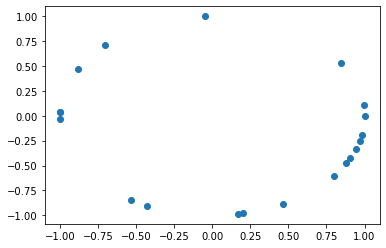

In [4]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

The environment class allows to create 3 types of linear bandit problems: 
* 'fixed' : normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'arbitrary': at each round, an 'arbitrary' set of actions is chosen and here we decided to simply create a pool of (d x K) vectors and let the environment choose K of them without replacement at each round;
* 'iid' : at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

In [5]:
class LinearBandit(Environment):
    
    def __init__(self, theta, K, pb_type, model='gaussian', var=1., fixed_actions=None):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.model = model
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        self.pb_type = pb_type
        if self.pb_type not in ['fixed', 'iid', 'arbitrary']:
            raise ValueError(pb_type, "this type of problem is unknown, either change it or define it :)")
            
        #Now, set up the game for the given type:
        if self.pb_type == 'fixed':
            if fixed_actions is not None:

                self.K, action_dim = fixed_actions.shape #safety reset of self.K in case different
                if action_dim != self.d: # safety check
                    raise ValueError(fixed_actions, "actions dimension and theta mismatch: fix your actions.")
                self.fixed_actions = fixed_actions
            else:
                #create a fixed action set:
                self.fixed_actions = randomActionsGenerator(self.K, self.d)
            
            self.current_action_set = self.fixed_actions
            
        elif self.pb_type == 'arbitrary':
            #generate d*K actions and then sample K from this set at each round
            # Note any other way to generate an arbitrary sequence can be used
            self.pool_of_actions = randomActionsGenerator(self.d * self.K, self.d)
            # select K actions without replacement in the pool:
            self.current_action_set = self.pool_of_actions[np.random.choice(self.d*self.K, self.K, replace=False)]
        elif self.pb_type == 'iid':
            # generate a random set
            self.current_action_set = randomActionsGenerator(self.K, self.d)       
            
        
    def get_action_set(self):
        if self.pb_type == 'fixed':   
            self.current_action_set = self.fixed_actions
            return self.current_action_set
        elif self.pb_type == 'iid':
            self.current_action_set = randomActionsGenerator(self.K, self.d)
            return self.current_action_set
        elif self.pb_type == 'arbitrary':
            self.current_action_set = self.pool_of_actions[np.random.choice(self.d*self.K, self.K, replace=False)]
            return self.current_action_set
        
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        if self.model == 'gaussian':
            return np.random.normal(mean, scale=self.var)
        else:#add bernoulli model option
            raise NotImplementedError('only Gaussian rewards are implemented so far')
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)
        
        


# Linear Bandit Agents

For your report, **please export only the notebook from this cell on**. 

**Your Name**: Andjela Todorovic

**Your co-author's name**: NA



## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement an LinEpsilonGreedy agent as seen in the previous Lab. Do you think these agents can have a sublinear regret ? 

*[Your answer]

***Anwser:***

*With a considerable number of simulations (Monte Carlo parameter Nmc) and a fairly distant finite horizon T, LinUniform agent can not be sublinear, since it makes its decisions completely randomly. 
In the case of LinEpsilonGreedy agent, it depends on the value of the parameter $\epsilon$.Decreasing $\epsilon$ will consequently make the regret of our agent become more and more sublinear since we will choose the next action, based on the parameter $\hat{\theta}$ with a higher probability.
Note that for $\epsilon = 1$ we get the same LinUniform agent.*


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards. 

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $uv^\top$, of vectors u and v.

*[Your answer]

***Anwser:***

*We can compute inverse by using the Sherman–Morrison formula.*
<center>

*Lemma: If $A$ and $A+B$ are _invertible_, and $B$ has rank 1, then let $g=trace(BA−1)$.     
Then $g≠−1$ and $(A+B)^{−1} = A^{−1}− \frac{1}{1+g} * A^{−1}BA^{−1}$*
    
    
*In our case, this translates to  $
 (A + uv^\top)^{-1} = A^{-1} - \frac{A^{-1} uv^\top A^{-1}}{1+v^\top A^{-1}u}
 $*
    
*where $A \in \mathbb{R}^{n \dot n}$ &mdash; invertible square matrix, $u, v$ are *n-*dimensional vectors ($u, v \in \mathbb{R}^{n}$). Obviously, we need to assure that $v^{\top} \cdot A^{-1} \cdot u \neq -1$.*

*Also, in our case, $V_i(\lambda)$ can be considered as $A$ and at every update with the previously chosen action $a_i$, ($a_i \sim u = v$), we can apply:*

$V_{i+1}^{-1} = (V_i + a_i \cdot a_i^{\top})^{-1} = V_i^{-1} - \frac{V_i^{-1} \cdot a_i \cdot a_i^{\top} \cdot V_i^{-1}}{1 + a_i^{\top} \cdot V_i^{-1} \cdot a_i}.$

    
*Sherman-Morisson formula is a direct consequence from the properties of the general linear group on square matrices : adding a little perturbation to an invertible matrix is still an invertible matrix.*

</center>
 
*Using this we only inverse the covariance matrix at initialization of the algorithm and iteratively obtain the new inverse each turn, inducing less computing complexity.*


* **Implement and additional exploration hyper-parameter**: It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1 $. 
Please implement this little modification of LinUCB. 

You may wonder why one would do that and it is a legitimate question. We guide you to explore this question further below, bear with us :)

*[Your answer]

***Anwser:***

*It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter . Adding this hyperparameter  is a way to apply scalability over the UCB algorithm. It operates in the trade-off between exploration and explotation: the smaller this parameter gets, the more likely we'll exploit than explore (and vice versa).
Multiplying it to the confidence bonus is a way of penalizing the bonus part in the UCB formula, and so having  implies to have a greedier algorithm than original UCB. Behind this technique, we elevate the risk to compute a  being outside the high-probability confidence region, because this was ensured by the beta component. Having  close to 0 means we rely more on the regularized least squares estimate of  to make the choice of the next arm. By discounting the bonus part, we carry less on the history of taken actions and received rewards, and in our case it is a good idea to do so as we always start by pulling a random arm at time  and this can have a negative impact on the evolution of the algorithm. In practice, we see that a value of  near 0.5 produces better results than no discount at all.*


### Uniform random policy

In [6]:
class LinUniform(Agent):
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  #@staticmethod
  def name(self):
    return 'Unif'

  

### Lin-$\epsilon$-Greedy policy:

In [7]:
class LinEpsilonGreedy(Agent):
    def __init__(self, d, lambda_reg, eps=0.1):
        """Constructor for the LinEpsilonGreedy agent.

        Args:
            d ([type]): [description]
            lambda_reg ([type]): Regularization
            eps (float, optional): Eps constant. Defaults to 0.1.
        """
        self.eps = eps  # exploration probability
        self.d = d
        self.lambda_reg = lambda_reg
        self.reset()

    def reset(self):
        self.t = 0
        self.hat_theta = np.zeros((1,self.d))
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.b_t = np.zeros((1,self.d))

    def get_action(self, arms):
        K, _ = arms.shape
        if np.random.random() < self.eps:
            action = arms[np.random.choice(K)]
        else:
            means = np.zeros(K)
            for i, a in enumerate(arms):
                a = np.expand_dims(a, 0)
                means[i] = np.dot(a, self.hat_theta.T)[0][0]
            action = arms[np.argmax(means)]
        return action

    def receive_reward(self, chosen_arm, reward):
        """
        update the internal quantities required to estimate the parameter theta using least squares
        """

        self.t += 1
        chosen_arm_vec = np.expand_dims(chosen_arm, 0)
        self.b_t += reward * chosen_arm_vec
        self.cov += chosen_arm_vec.T @ chosen_arm_vec
        self.invcov = np.linalg.inv(self.cov)  # TODO Optimize, to check
        self.hat_theta = (self.invcov @ self.b_t.T).T

    # @staticmethod

    def name(self):
        return 'LinEGreedy('+str(self.eps)+')'

### Lin-UCB: The optimistic way

In [8]:
class LinUCB(Agent):

    def __init__(self, d, delta, lambda_reg, alpha=1.):
        self.d = d
        self.t = 0
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.cov = self.lambda_reg * np.identity(d)
        # TODO: instantiate alpha
        self.alpha = alpha

        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        self.hat_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.b_t = np.zeros((1,self.d))

    def get_action(self, arms):
        """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : vector (chosen arm array of features)
        """
        # compute the UCB of each of the arm in arms, here arms are vectors
        n_arms = arms.shape[0]
        ucbs = np.zeros(n_arms)
        beta_t = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1/self.delta) +
                                                    self.d*np.log(1+self.t/(self.lambda_reg*self.d)))

        for i in range(n_arms):
            a = np.expand_dims(arms[i], 0)
            greedy_term = float(self.hat_theta @ a.T)
            bonus_term = float(beta_t * np.sqrt(a @ self.invcov @ a.T))
            ucbs[i] = greedy_term + self.alpha * bonus_term
        return arms[np.argmax(ucbs)]

    def receive_reward(self, chosen_arm, reward):
        """
        update the internal quantities required to estimate the parameter theta using least squares
        """
        self.t += 1
        chosen_arm_vec = np.expand_dims(chosen_arm, 0)
        self.b_t += reward * chosen_arm_vec
        self.cov += chosen_arm_vec.T @ chosen_arm_vec
        self.invcov = np.linalg.inv(self.cov)  # TODO Optimize, to check
        self.hat_theta = (self.invcov @ self.b_t.T).T
        pass

    def name(self):
        return "LinUCB("+str(self.alpha)+')'

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 


    
*Base step:* $t = 0$ and $t = 1$

At t = 0 we have Gaussian prior on $\theta$  with distribution $\pi_0 \sim \mathcal{N}({\mu_0},{\Sigma_0 = \sigma_0*I_d})$\
Supposing the posterior distribution has probability distribution $\pi$ and PDF $f$, we can write its log as:
$\log(\pi (\theta, (A_1, Y_1)) = -\frac{1}{2}(\theta - \mu_0)^T\Sigma_0^{-1}(\theta - \mu_0) - \frac{1}{2\sigma_0^2}(Y_1-A_1^T\theta)^T(Y_1-A_1^T\theta) + cste $


$= -\frac{1}{2}\theta^T(\Sigma_0^{-1} + \frac{1}{\sigma^2}A_1A_1^T)\theta+\theta^T(\Sigma_0^{-1}\mu_0+\frac{1}{\sigma^2}A_1Y_1)+cste1$

(here we utilize the fact that $cste1$ is also a constant equal to $cste + \frac{1}{2}[\mu_0^T\Sigma_0^{-1}\mu_0] + \frac{1}{2\sigma_0^2}[Y_1^TY_1]$)


We can rewrite the previous equation as :

$\log(\pi (\theta, (A, Y)) = -\frac{1}{2}\theta^T\Sigma_1^{-1}\theta-\theta^T\Sigma_1^{-1}\mu_1+\mu_1^T\mu_1 + cste1 = -\frac{1}{2}(\theta-\mu_1)^T\Sigma_1^{-1}(\theta-\mu_1) + cste1 $

by simply deffining $\Sigma^{-1}_1$ and $\mu_1$ as follows:

$\Sigma^{-1}_1 = \Sigma_0^{-1} + \frac{1}{\sigma^2}A_1A_1^T = \frac{1}{\sigma^2}I_d + \frac{1}{\sigma^2}A_1A_1^T$

$\mu_1 = \Sigma_1(\Sigma_0^{-1}\mu_0 + \frac{Y}{\sigma^2}A) = \frac{1}{\sigma^2}Y_1A_1^T $

Having in mind that $cste1$ is constant, we can see that the posterior distribution of $\theta$ follows $ \mathcal{N}({\mu_1},{\Sigma_1})$.


*Inductive hypothesis:* 

At time $t > 0$, the posterior is follwing $ \mathcal{N}({\mu_t},{\Sigma_t})$ 

with:

$\Sigma^{-1}t = \frac{1}{\sigma_0^2}I_d + \frac{1}{\sigma^2}\sum{i=1}^{t}A_iA_i^T  (1)$ 

$\mu_t = \frac{1}{\sigma^2}\sum_{i=1}^{t}Y_iA_i^T   (2)$

*Inductive step:*

$\log(\pi (\theta, (A_t+1, Y_t+1)) = -\frac{1}{2}(\theta - \mu_t)^T\Sigma_t^{-1}(\theta - \mu_t) - \frac{1}{2\sigma_t^2}(Y_{t+1}-A_{t+1}^T\theta)^T(Y_{t+1}-A_{t+1}^T\theta) + cste $

$= -\frac{1}{2}\theta^T(\Sigma_t^{-1} + \frac{1}{\sigma^2}A_{t+1}A_{t+1}^T)\theta-\theta^T(\Sigma_t^{-1}\mu_t+\frac{1}{\sigma^2}A_{t+1}Y_{t+1})+ cste$

Using inductive hypothesis:

$\Sigma^{-1}{t+1} = \Sigma_t^{-1} + \frac{1}{\sigma^2}A{t+1}A_{t+1}^T = \frac{1}{\sigma_0^2}I_d + \frac{1}{\sigma^2}\sum_{i=1}^{t+1}A_iA_i^T , from (1)$

$\mu_{t+1} = \Sigma_{t+1}(\Sigma_t^{-1}\mu_t + \frac{Y}{\sigma^2}A) = \frac{1}{\sigma^2}\sum_{i=1}^{t+1}Y_iA_i^T, from (2)$,

Therefore:

$\log(\pi (\theta, (A, Y)) = -\frac{1}{2}\theta^T\Sigma_{t+1}^{-1}\theta-\theta^T\Sigma_{t+1}^{-1}\mu_1+\mu_1^T\mu_1 + cste $

$= -\frac{1}{2}(\theta-\mu_1)^T\Sigma_{t+1}^{-1}(\theta-\mu_1) + cste $

Finaly, we conclude that at time $t+1$, the posterior on $\theta \sim \mathcal{N}(\mu_{t+1},\Sigma_{t+1})$ with:

$\Sigma_{t+1} = (\frac{1}{\sigma_0^2}I_d + \frac{1}{\sigma^2}\sum_{i=1}^{t+1}A_iA_i^T)^{-1}$ 

$\mu_{t+1} = \frac{1}{\sigma^2}\sum_{i=1}^{t+1}Y_iA_i^T $



* **Implementation of a LinTS (Linear Thompson Sampling) agent**.

In [14]:
import numpy as np 

In [15]:
class LinTS(Agent):

  def __init__(self, T, d, delta, lambda_reg, sigma_0=1):
    """
    T : Number of done actions for the calculation of thetas
    d : Dimension of action
    delta : Probability of theta non being within the high-confidence region
    lambda_reg : Regularization parameter of theta norm
    sigma_0 : Covariance parameter
    """
    self.t = 0
    self.d = d
    self.b = np.zeros(self.d)
    self.sigma_0 = sigma_0
    self.cov_matrix_theta_prior = self.sigma_0*np.eye(self.d)
    self.mu_posterior = 0
    self.sigma_matrix = np.eye(self.d)
    self.sigma_posterior = np.linalg.pinv(self.sigma_matrix)
    self.sigma_environment = 1

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.cov_matrix_theta_prior = self.sigma_0*np.eye(self.d)
    self.mu_posterior = 0
    self.sigma_matrix = np.eye(self.d)
    self.sigma_posterior = np.linalg.pinv(self.sigma_matrix)
    self.t = 0
    self.b = np.zeros(self.d)
    
  def get_action(self, arms):
        
    K, _ = arms.shape
    if self.t == 0 :
      chosen_arm = arms[np.random.randint(0,high=K)]
    else :
      thetas = np.random.multivariate_normal(
          self.mu_posterior, self.sigma_posterior
          )
      chosen_arm = arms[np.argmax(arms@thetas)]
    
    self.t += 1
    self.sigma_matrix += (self.sigma_environment ** (-2)
        * np.outer(chosen_arm, chosen_arm)
        + np.linalg.pinv(self.cov_matrix_theta_prior))
    self.sigma_posterior = np.linalg.pinv(self.sigma_matrix)
    self.mu_posterior = (self.sigma_environment ** (-2)
        * self.sigma_posterior @ self.b)

    return chosen_arm

  def receive_reward(self, chosen_arm, reward):
    self.b += reward*chosen_arm

  def name(self):
    return "LinTS_sigma0=" + str(self.sigma_0)

# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [16]:
def play(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent. 
    Return the agent's name (string) and the collected data in an nd-array.
    """
    
    data = np.zeros((Nmc, T))
    
    
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set) 
            # Note that the main difference with the previous lab is that now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

### Default settings
These should be good but feel free to try others, please highlight your changes wherever necessary.

In [17]:
d = 2  # dimension
K = 5  # number of arms

# parametor vector \theta, normalized :
# theta = randomActionsGenerator(1,d)
theta = np.array([0.45, 0.5])
theta /= np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10




In [18]:
# three environments

iid_env = LinearBandit(theta, K, pb_type='iid') 

fixed_actions = np.array(([1,0.1],[0.1,1],[0.3,0.4]))# or... #randomActionsGenerator(K,d)
fixed_env = LinearBandit(theta, K, pb_type='fixed', fixed_actions=fixed_actions) # check if gaps are small
print(fixed_env.get_means())

arbitrary_env = LinearBandit(theta, K, pb_type='arbitrary')


  
 

[0.74329415 0.81019062 0.49800708]


In [19]:
# policies

linucb = LinUCB(d, delta, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
lints = LinTS(T, d, delta, lambda_reg=1., sigma_0=1)


# Example question: Which baseline is the strongest, LinEpsilonGreedy or LinUniform?
This is a running demo, please follow this "template" in the questions below: 1/ experiment setup (choose environment(s), choose policies and parameters, 2/ plot, 3/ conclude by making observations on your results and responding to the question. If something catches your attention and you want to investigate further, please concisely write up what you want to test and why, as well as addtional conclusions.

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


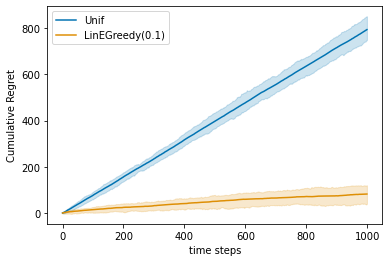

In [20]:
## iid environment
e_greedy_vs_unif_iid = experiment(iid_env, [uniform, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_iid, q=10)

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


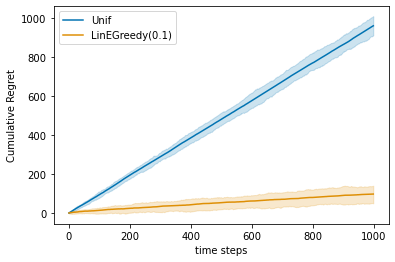

In [21]:
## arbitrary environment
e_greedy_vs_unif_arb = experiment(arbitrary_env, [uniform, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_arb, q=10)

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


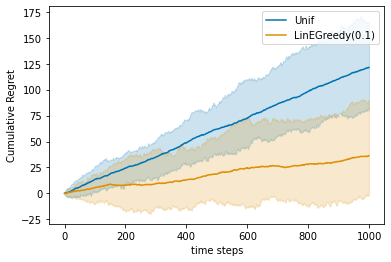

In [22]:
## fixed-actions environment
e_greedy_vs_unif_fixed = experiment(fixed_env, [uniform, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_fixed, q=10)

**Observations**: We tested LinEspilonGreedy and Uniform on all three environment types and LinEpsilonGreedy is stronger (it has lower regret) in all cases. However, we remark that its regret seems linear in all cases as expected due to the non-diminishing amount of exploration, **perhaps it would be interesting to see what happens when we remove this forced exploration?** We note that the difference between Uniform and EGreedy is significantly smaller in the fixed action problem, which is likely due to the reasonably small gaps (~0.05) in this problem (see env setup in above cell). 

**We quickly run the experiment suggested above, to check how Greedy ($\epsilon=0$) performs:**

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()
C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()
C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


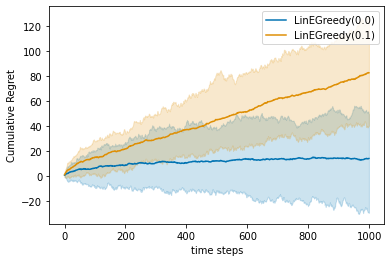

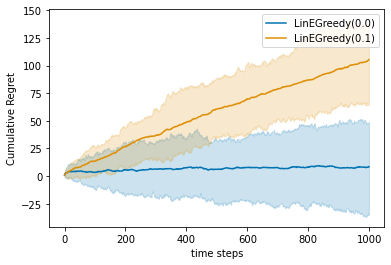

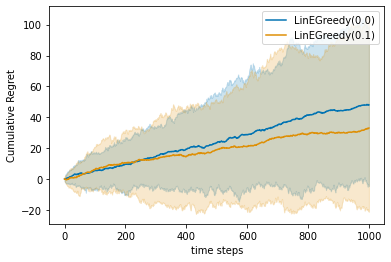

In [23]:
greedy_iid = experiment(iid_env, [greedy, e_greedy], Nmc=N, T=T)
greedy_arb = experiment(arbitrary_env, [greedy, e_greedy], Nmc=N, T=T)
greedy_fixed = experiment(fixed_env, [greedy, e_greedy], Nmc=N, T=T)

plot_regret(greedy_iid, q=10)
plot_regret(greedy_arb, q=10)
plot_regret(greedy_fixed, q=10)

In the arbitrary and iid environments, Greedy seems to be learning! This is surprising and could be investigated further but it is beyond the present question's scope. In the fixed-actions environment, however, greedy has a linear regret. **We conclude that Greedy may actually be quite a strong baseline in iid and arbitrary environments**.

# Question: Is LinUCB better than the baseline LinEpsilonGreedy? 
Compare the two methods on all environments and conclude. In light of the above example, decide which values of epsilon you want to try in your comparisons and explain your choices following the suggested template.

Fixed-action environment

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


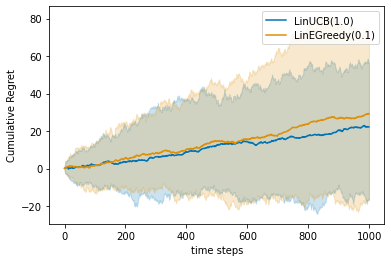

In [24]:
e_greedy_vs_unif_fixed = experiment(fixed_env, [linucb, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_fixed, q=10)

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


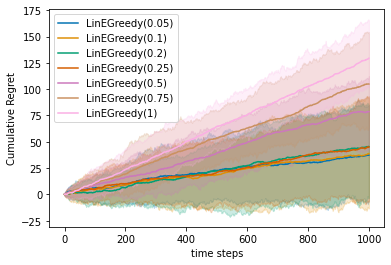

In [44]:
e_greedy_vs_unif_fixed_multiple_eps = experiment(fixed_env, [LinEpsilonGreedy(d, lambda_reg=1., eps = epsilon) for epsilon in [0.05,0.1,0.2,0.25,0.5,0.75,1]], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_fixed_multiple_eps, q=10)

Arbitary environment

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


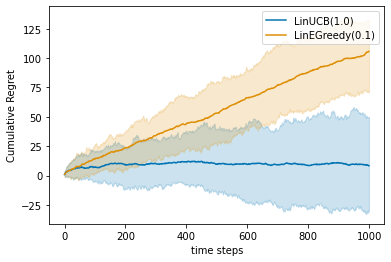

In [25]:
e_greedy_vs_unif_arb = experiment(
    arbitrary_env, [linucb, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_arb, q=10)

iid environment

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


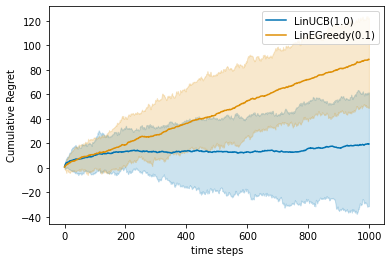

In [26]:
e_greedy_vs_unif_iid = experiment(iid_env, [linucb, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_iid, q=10)

**Conclusions**: In general, LinUCB performs better (has lower regret) than LinEGreedy, even in the most difficult environment such as fixed-action environment. 
By observing different parameters $epsilon$ in fixed-action environment, we can see that values of 0.05 or 0.1 give the optimal results.
There is a possibility of regularization parameter lambda_reg having impact on results but it shouldn't be a dramatic change in plots.

# Question: What is the role of $\alpha$ for LinUCB ?

In the question above, we saw that the fixed-actions setting is the most interesting because it is the most difficult. For this question, we fix the environment to fixed-actions. 
Compare the behavior of various instantiations of LinUCB using different values of the scaling hyper-parameter $\alpha$ and conclude on its usefulness / risks.


C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


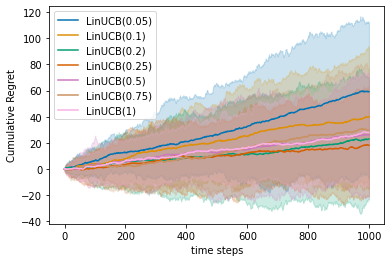

In [35]:
linUCB_var_alpĥa = experiment(fixed_env, [LinUCB(d, delta, lambda_reg=1., alpha=alpha) for alpha in [0.05,0.1,0.2,0.25,0.5,0.75,1]], Nmc=N, T=T)

plot_regret(linUCB_var_alpĥa, q=10)
    

**Conclusions**: The optimal curves are obtained for $\alpha < 1$ (e.g. 0.2 or 0.25), but not necessarily when it is very small (e.g. 0.1 or 0.05). It means, that the agent should not only dedicate itself to the exploitation, but it is also necessary to explore in a certain magnitude, otherwise, as it was exposed in the first section, there is the danger of getting stuck in the local optima.

 Therefore, based on the experiments and the deductions made, to avoid suboptimality we can assign $\alpha$ values such as $0.2$ for this problem.

# Question: Is Thompson Sampling better than LinUCB?
Compare these two policies in all environments and conclude. 


Fixed-action environment

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


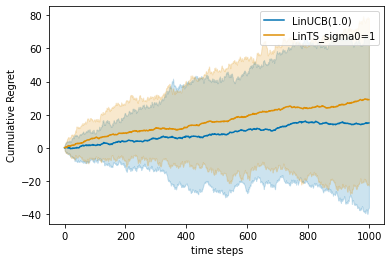

In [28]:
linucb_vs_lints_fixed = experiment(fixed_env, [linucb, lints], Nmc=N, T=T)

plot_regret(linucb_vs_lints_fixed, q=10)

Arbitary environment

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


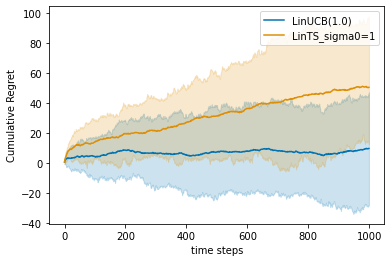

In [32]:
linucb_vs_lints_arb = experiment(arbitrary_env, [linucb, lints], Nmc=N, T=T)

plot_regret(linucb_vs_lints_arb, q=10)

C:\Users\mdsp\Downloads\Lab on linear bandits-20220113\display.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


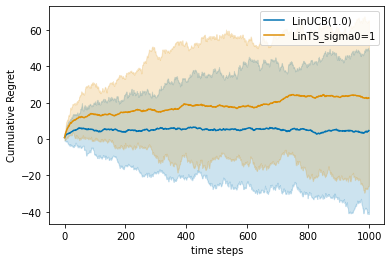

In [33]:
linucb_vs_lints_iid = experiment(iid_env, [linucb, lints], Nmc=N, T=T)

plot_regret(linucb_vs_lints_iid, q=10)

**Conclusions**: Globally, LinUCB performs better than the LinTS (hence the lower regret) , although the difference is more prominent in the case of a fixed environment, as compared to arbitary environment and iid environment. It could be confirmed by testing it on more examples (increasing Nmc), for these algorithms are still highly stochastic. Furthermore, we saw two different way to fine-tune the exploitation/exploration trade-off with tuning the parameters of LinTS and LinUCB models. In our bandit problem, we see that both approaches are efficient to obtain a low regret.